Load in Data

In [1]:
data_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/point measurements from convergent maps.csv'

In [ ]:
import pandas as pd
df = pd.read_csv(data_path)

In [ ]:
from scipy.stats import kruskal, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    return '#%02x%02x%02x' % rgb_color

def lighten_color(rgb, factor):
    return tuple(min(int(c + (255 - c) * factor), 255) for c in rgb)

def generate_grey_shades(primary_hex, n):
    base_rgb = hex_to_rgb(primary_hex)
    return [rgb_to_hex(lighten_color(base_rgb, i / (n * 1.8))) for i in range(n)]

def plot_horizontal_boxplot_with_stats(
    df,
    xlabel="Value",
    out_dir=None,
    primary_color="#8E8E8E",
    secondary_color="#211D1E"
):
    df = df.copy()
    label_col = df.columns[0]
    df = df.set_index(label_col)
    df.index.name = 'Category'

    # Sort categories by median
    medians = df.median(axis=1).sort_values(ascending=False)
    df = df.loc[medians.index]

    # Stats
    print("Wilcoxon Signed-Rank Test (median ≠ 0):")
    for row_name, row in df.iterrows():
        values = row.dropna().values
        if len(values) > 0:
            try:
                stat, p = wilcoxon(values)
                print(f"  {row_name}: stat={stat:.3f}, p={p:.4f}")
            except ValueError:
                print(f"  {row_name}: Invalid (likely all zeros or constant values)")
        else:
            print(f"  {row_name}: No valid data")

    groups = [row.dropna().values for _, row in df.iterrows()]
    if len(groups) > 1:
        kw_stat, kw_p = kruskal(*groups)
        print(f"\nKruskal-Wallis Test across categories: stat={kw_stat:.3f}, p={kw_p:.4f}")

    # Reshape for plotting
    df_long = df.reset_index().melt(id_vars='Category', var_name='Observation', value_name='Value')

    # Create shade palette from primary color
    n_categories = df.shape[0]
    shade_palette = generate_grey_shades(primary_color, n_categories)
    palette_map = dict(zip(df.index.tolist(), shade_palette))

    # Plot
    plt.figure(figsize=(10, 6))
    sns.set(style='white', font_scale=1.5)
    ax = sns.boxplot(
        data=df_long,
        y='Category',
        x='Value',
        orient='h',
        palette=palette_map
    )

    # Dashed line at zero
    ax.axvline(0, linestyle='--', color='#B0B0B0', linewidth=2)

    # Style
    sns.despine()
    plt.tick_params(labelsize=20)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel('', fontsize=20)
    plt.title('', fontsize=20)
    plt.tight_layout()

    # Save if requested
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, "horizontal_boxplot.svg")
        plt.savefig(out_path, format="svg")
        print(f"Saved SVG to: {out_path}")

    plt.show()

Wilcoxon Signed-Rank Test (median ≠ 0):
  Convergent: stat=0.000, p=0.0005
  DBS: stat=0.000, p=0.0078
  TMS: stat=1.000, p=0.0156
  Default: stat=0.000, p=0.0005
  Lesion: stat=5.000, p=0.0703
  Amnesia Network: stat=7.500, p=0.0103
  Neurosynth Memory: stat=12.500, p=0.0366

Kruskal-Wallis Test across categories: stat=14.423, p=0.0252
Saved SVG to: /Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/memory_ccm/Figures/convergent_causal_map/boxplots/horizontal_boxplot.svg


/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_3221/2922389290.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


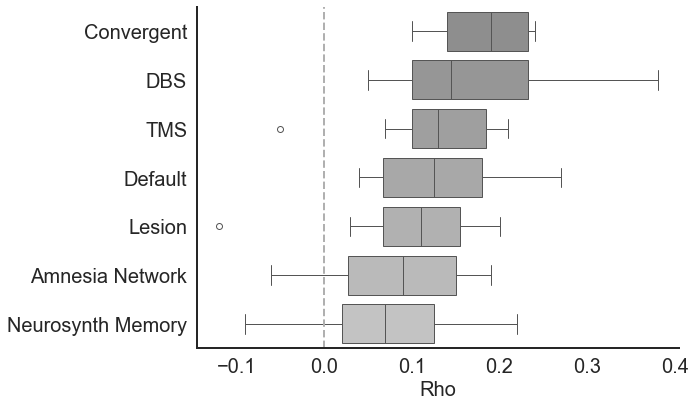

In [22]:
# Run updated version
# Rerun with the current CSV-based dataframe
plot_horizontal_boxplot_with_stats(
    df,
    xlabel="Rho",
    out_dir='/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/memory_ccm/Figures/convergent_causal_map/boxplots'
)


Simple boxplot from CSV

5
5


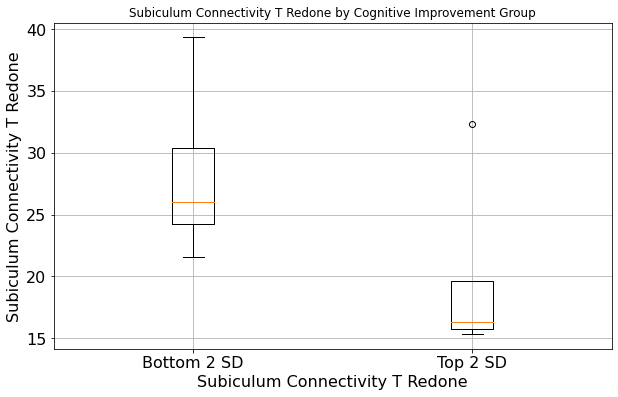

Kruskal-Wallis Test: stat=3.153, p=0.0758
Mann-Whitney U Test: U=4.000, p=0.0952
Mood's Median Test: stat=0.991, p=0.3218


In [14]:
import pandas as pd
from scipy.stats import mood, mannwhitneyu, kruskal, ks_2samp
import matplotlib.pyplot as plt

# Load the CSV
file_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/metadata/pd_only.csv'
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip()

# Identify relevant column names
dv_col = "Percent Cognitive Improvement"
iv_col = "Subiculum Connectivity T Redone"

# # Calculate mean and std dev
# mean_dv = df[dv_col].mean()
# std_dv = df[dv_col].std()

# # Define top/bottom 2 SD groups
# high_group = df[df[dv_col] >= mean_dv + (1 * std_dv)]
# low_group = df[df[dv_col] <= mean_dv - (1 * std_dv)]

X = 5  # Define the number of patients for each group
high_group = df.nlargest(X, dv_col)
low_group = df.nsmallest(X, dv_col)
print(high_group.shape[0])
print(low_group.shape[0])

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [low_group[iv_col], high_group[iv_col]],
    labels=["Bottom 2 SD", "Top 2 SD"]
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(iv_col, fontsize=16)
plt.ylabel(iv_col, fontsize=16)
plt.title("Subiculum Connectivity T Redone by Cognitive Improvement Group", fontsize=16)
plt.ylabel(iv_col)
plt.title("Subiculum Connectivity T Redone by Cognitive Improvement Group")
plt.grid(True)
plt.savefig('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/manuscripts/sbc_and_cognition/sbc_cognition_manuscripts/alz_and_dem_08/revision_01/revision_figs/pd.svg')
plt.show()


# Perform Mood's median test
stat, p_value = mood(high_group[iv_col].dropna(), low_group[iv_col].dropna())
# Perform Mann-Whitney U test
# Perform Kruskal-Wallis test
kw_stat, kw_p = kruskal(high_group[iv_col].dropna(), low_group[iv_col].dropna())
u_stat, u_p_value = mannwhitneyu(high_group[iv_col].dropna(), low_group[iv_col].dropna(), alternative='two-sided')

# Print results
print(f"Kruskal-Wallis Test: stat={kw_stat:.3f}, p={kw_p:.4f}")
print(f"Mann-Whitney U Test: U={u_stat:.3f}, p={u_p_value:.4f}")
print(f"Mood's Median Test: stat={stat:.3f}, p={p_value:.4f}")


In [19]:
low_group[iv_col]

0     30.376565
10    39.316089
14    26.016428
17    24.237392
Name: Subiculum Connectivity T Redone, dtype: float64

In [20]:
high_group[iv_col]

1     16.295870
20    32.297293
23    15.353030
Name: Subiculum Connectivity T Redone, dtype: float64

In [21]:
high_group

,subject,Age,Hippocampus GM Vol,Parahippocampal Gyrus GM Vol,Entorhinal Cortex GM Vol,Normalized Percent Cognitive Improvement,Z_Scored Percent Cognitive Improvement By Origin Group,Z-Scored Percent Cognitive Improvement,Percent Cognitive Improvement,Z-Scored Subiculum T By Origin Group,...,DECLINE,Cognitive_Improve,Z-Scored Cognitive Baseline,Z-Scored Cognitive Baseline (Lower is Better),Min Max Normalized Baseline,MinMaxNormBaseline Higher is Better,ROI to Alz Max,ROI to PD Max,Standardzied AD Max,Standardized PD Max
1,2,50.0,7.3398,7.3202,4.3873,0.992806,1.331414,1.331414,2.158273,-0.930548,...,False,Yes,-0.935174,-0.935174,0.375,0.375,11.487188,4.942970,-0.759238,-1.629565
20,28,56.0,9.2345,8.6010,5.0002,1.000000,1.336814,1.336814,2.173913,1.355046,...,False,Yes,-1.345113,-1.345113,0.250,0.250,24.395433,24.956701,1.465638,1.126720
23,31,64.0,0.0067,0.0478,0.0376,0.666667,1.086636,1.086636,1.449275,-1.065220,...,False,Yes,-1.345113,-1.345113,0.250,0.250,10.930371,11.599140,-0.855211,-0.712879


In [22]:
low_group

,subject,Age,Hippocampus GM Vol,Parahippocampal Gyrus GM Vol,Entorhinal Cortex GM Vol,Normalized Percent Cognitive Improvement,Z_Scored Percent Cognitive Improvement By Origin Group,Z-Scored Percent Cognitive Improvement,Percent Cognitive Improvement,Z-Scored Subiculum T By Origin Group,...,DECLINE,Cognitive_Improve,Z-Scored Cognitive Baseline,Z-Scored Cognitive Baseline (Lower is Better),Min Max Normalized Baseline,MinMaxNormBaseline Higher is Better,ROI to Alz Max,ROI to PD Max,Standardzied AD Max,Standardized PD Max
0,1,57.0,7.6610,6.0859,3.9153,-2.609929,-1.372562,-1.372562,-5.673759,1.080695,...,True,No,-0.115295,-0.115295,0.625,0.625,22.020300,20.467840,1.056258,0.508516
10,15,46.0,6.0731,6.5172,3.6852,-3.513889,-2.051014,-2.051014,-7.638889,2.357590,...,True,No,1.114522,1.114522,1.000,1.000,23.430082,33.143996,1.299249,2.254272
14,21,58.0,8.2139,7.1176,3.9484,-4.535211,-2.817552,-2.817552,-9.859155,0.457907,...,True,No,0.294644,0.294644,0.750,0.750,19.765137,23.255821,0.667556,0.892476
17,24,NaN,NaN,NaN,NaN,-4.333333,-2.666036,-2.666036,-9.420290,0.203795,...,True,No,-1.345113,-1.345113,0.250,0.250,18.524311,15.431603,0.453686,-0.185073
